In [1]:
import ROOT
import Geant4
from ROOT import TCanvas, TColor, TGaxis, TH1F, TPad
from Geant4 import mm, cm, MeV, G4ThreeVector , GeV
from math import *
import os

Welcome to JupyROOT 6.18/04

**************************************************************
 Geant4 version Name: geant4-10-06-patch-01    (14-February-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

Visualization Manager instantiating with verbosity "warnings (3)"...


In [2]:
visual = 10

os.environ['DISPLAY']=':1.0'
from mayavi import mlab
mlab.options.offscreen = True
mlab.init_notebook('x3d')

fcurrent = None
def fc():
    global fcurrent
    fcurrent = mlab.figure(fcurrent)
    return fcurrent
def vrmlview(fname):
    mlab.clf()
    from mayavi.sources.vrml_importer import VRMLImporter
    r = VRMLImporter()
    r.initialize(fname)
    engine = mlab.get_engine()
    f = fc()
    engine.add_source(r)
    f
    return f

Notebook initialized with x3d backend.


In [3]:
def material(name):
    m = Geant4.G4NistManager.Instance().FindOrBuildMaterial(name)
    assert m is not None
    return m

def particle(name):
    p = Geant4.G4ParticleTable.GetParticleTable().FindParticle(name)
    assert p is not None
    return p

In [4]:
class SomeBox:
    def __init__(self, name, materialName, parent, x, y, z, sx, sy, sz):
        self.name     = name
        self.solid    = Geant4.G4Box(self.name.lower()+"_box", 0.5*sx, 0.5*sy, 0.5*sz)
        m = material(materialName)
        self.logical  = Geant4.G4LogicalVolume( self.solid, m, self.name, None, None, None, True)
        r0 = G4ThreeVector(x, y, z)
        self.physical = Geant4.G4PVPlacement(None, r0, self.logical, self.name, parent, False, 0)

class World(SomeBox):
    def __init__(self, x, y, z, sx, sy, sz):
        super().__init__("World", "G4_Galactic", None, x, y, z, sx, sy, sz)

Оценка Размеров Мира

В направлении по оси z испускаются фотоны, в 5 см ортогонально пучку расположен куб из чистого германия (детектор), размер ребра 5 см, за ним вплотную – кубический свинцовый поглотитель; размер ребра 20 см

Координаты испускания(0, 0, 0) Расчёт по координате z: Положение центра детектора = Точка испускания + расстояние до переднего ребра + расстояние от ребра до центра детектора(половина размера детектора) = 0 + 5 + 1/25 = 7.5 см Положение центра поглотителя = Точка испускания + расстояние до переднего ребра детектора + размер детектора + расстояние от ребра до центра поглотителя(половина размера поглотителя) = 0 + 5 + 5 + 1/220 = 20 cm

Размер мира по оси z = Точка испускания + расстояние до переднего ребра детектора + размер детектора + размер поглотителя = 0 + 5 + 5 + 20 = 30 см

Размер мира по оси x = Размер по оси y = Половина размера поглотителя (т.к. он имеет наибольший размер)= 10 см

Т.к. каждый размер будет делится пополам - домножим каждый на 2 Получаем:

[20cm, 20cm, 60*cm]

Чтобы размеры были не "впритык" добавим по 10 см каждой оси

Итого [30cm, 30cm, 70*cm]

In [5]:
class DetectorConstructor(Geant4.G4VUserDetectorConstruction):
    def __init__(self):
        super().__init__()
        self.world          = World(0, 0, 0, 30*cm, 30*cm, 70*cm)
        self.calorimeter    = SomeBox("Calorimeter", "G4_Ge", self.world.logical, 0, 0, 7.5*cm, 5.0*cm, 5.0*cm, 5.0*cm)
        self.adsorber       = SomeBox("Adsorber", "G4_Pb", self.world.logical, 0, 0, 20*cm, 20*cm, 20*cm, 20*cm)

    def Construct(self):
        return self.world.physical

In [6]:
PhysicsList = Geant4.FTFP_BERT

In [7]:
class PrimaryGenerator(Geant4.G4VUserPrimaryGeneratorAction):

    def __init__(self):
        super().__init__()
        self.particlename = "gamma"
        self.energy  = 6.0*MeV
        self.gun   = Geant4.G4ParticleGun()
    
        self.particle = particle(self.particlename)
        self.gun.SetParticleDefinition(self.particle)

    def GeneratePrimaries(self, anEvent):
        p = Geant4.G4ThreeVector(0.0, 0.0, 0.0)
        self.gun.SetParticlePosition(p)
        self.gun.SetParticleEnergy(self.energy)
        
        phi   = ROOT.gRandom.Uniform(0.0, 2.0*pi)
        theta = acos(ROOT.gRandom.Uniform(cos(0.001*pi/180), 1.0))
        pdir  = Geant4.G4ThreeVector(sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta))

        self.gun.SetParticleMomentumDirection(pdir)
        
        self.gun.GeneratePrimaryVertex(anEvent)

In [8]:
class SensitiveDetector(Geant4.G4VSensitiveDetector):

    def __init__(self, detectorname, n, xmin, xmax):
        super().__init__()
        self.title  = detectorname + " energy deposition"
        self.hash   = hash(detectorname)
        self.name   = 'h%s'%self.hash # make identifier unique
        self.hist   = ROOT.TH1F(self.name, self.title, n, xmin, xmax)
        self.event_energy = 0.0
        self.total_energy = 0.0
        self.count_full_adsorb = 0

    def __hash__(self):
        # to use in checks etc.
        return self.hash

    def __str__(self):
        return "Detector:%s"%self.name

    def ProcessHits (self, step, rohistory):
        deposit = step.GetTotalEnergyDeposit() / MeV
        self.event_energy += deposit
        return True

    def event_reset(self):
        self.event_energy = 0.0
        
    def full_reset(self):
        self.event_energy = 0.0
        self.total_energy = 0.0
        self.count_full_adsorb = 0
        self.hist.Reset()
        
    def process(self):
        self.total_energy += self.event_energy
        self.hist.Fill(self.event_energy)
        if(self.event_energy >= 0.99*6.0):  #Полное поглощение
            self.count_full_adsorb += 1

In [9]:
class EventAction(Geant4.G4UserEventAction):

    def __init__(self, accumulator = None):
        super().__init__()
        self.detectors = set()
        self.count  = 0

    def BeginOfEventAction(self, event):
        self.count += 1
        for a in self.detectors:
            a.event_reset()

    def EndOfEventAction(self, event):
        for a in self.detectors:
            a.process()

    def register(self, a):
        assert a not in self.detectors
        self.detectors.add(a)
        
    def Reset(self): #Полный сброс
        self.count = 0
        for a in self.detectors:
            a.full_reset()

In [10]:
randEngine = Geant4.Ranlux64Engine()
Geant4.HepRandom.setTheEngine(randEngine)

manager = Geant4.gRunManager

constructor = DetectorConstructor()
manager.SetUserInitialization(constructor)
    
physics = PhysicsList()
manager.SetUserInitialization(physics)

generator = PrimaryGenerator()
manager.SetUserAction(generator)

#Создаем калориметер
calorimeter = SensitiveDetector("Calorimeter",100, 0, 10)
constructor.calorimeter.logical.SetSensitiveDetector(calorimeter)
#Создаем поглотитель
adsorber = SensitiveDetector("Adsorber", 100, 0, 10)
constructor.adsorber.logical.SetSensitiveDetector(adsorber)

eventcallback = EventAction()
manager.SetUserAction(eventcallback)
##Передаем объекты(калориметер и поглотитель) в События
eventcallback.register(calorimeter)
eventcallback.register(adsorber)

manager.Initialize()

<<< Geant4 Physics List simulation engine: FTFP_BERT


 FTFP_BERT : new threshold between BERT and FTFP is over the interval 
 for pions :   3 to 6 GeV
 for kaons :   3 to 6 GeV
 for proton :  3 to 6 GeV
 for neutron : 3 to 6 GeV

### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0


In [11]:
#Geant4.gApplyUICommand("/run/initialize")
Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/open VRML2FILE")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh false")
Geant4.gApplyUICommand("/vis/viewer/refresh")
Geant4.gApplyUICommand("/vis/scene/create")
Geant4.gApplyUICommand("/vis/scene/add/volume")
Geant4.gApplyUICommand("/vis/viewer/set/globalLineWidthScale 5")
#Geant4.gApplyUICommand("/vis/geometry/set/colour Calorimeter red")
Geant4.gApplyUICommand("/vis/drawVolume")
#Geant4.gApplyUICommand("/vis/viewer/flush")
Geant4.gApplyUICommand("/vis/viewer/set/viewpointVector -1 -1 0")
Geant4.gApplyUICommand("/vis/viewer/set/lightsVector -1 -1 0")
Geant4.gApplyUICommand("/vis/modeling/trajectories/create/drawByParticleID")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set gamma white")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set proton blue")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e- yellow")
Geant4.gApplyUICommand("/vis/modeling/trajectories/drawByParticleID-0/set e+ green")
Geant4.gApplyUICommand("/vis/sceneHandler/attach")
Geant4.gApplyUICommand("/vis/viewer/set/style wireframe")
Geant4.gApplyUICommand("/vis/set/lineWidth 4")
#Geant4.gApplyUICommand("/vis/viewer/set/viewpointThetaPhi 120. 150.")
Geant4.gApplyUICommand("/vis/viewer/zoom 1.")
Geant4.gApplyUICommand("/tracking/storeTrajectory 1")
Geant4.gApplyUICommand("/vis/scene/add/trajectories")
Geant4.gApplyUICommand("/vis/scene/add/hits")
Geant4.gApplyUICommand("/vis/scene/add/trajectories smooth")
Geant4.gApplyUICommand("/vis/scene/endOfEventAction accumulate")
Geant4.gApplyUICommand("/vis/scene/add/scale")
Geant4.gApplyUICommand("/vis/scene/add/axes")
Geant4.gApplyUICommand("/vis/scene/add/eventID")
Geant4.gApplyUICommand("/vis/scene/add/date")
Geant4.gApplyUICommand("/vis/viewer/set/autoRefresh true")
Geant4.gApplyUICommand("/vis/enable false")
import glob, os
for i in glob.glob("g4*.wrl"):
    print("Remove",i)
    os.unlink(i)

/tracking/storeTrajectory 1
/tracking/storeTrajectory 2


In [12]:
#Включаем визуализацию, делаем 10 запусков и сохраняем 3d модель
Geant4.gApplyUICommand("/vis/enable true")
manager.BeamOn(10)
import glob
print(glob.glob("*.wrl"))


phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

In [13]:
#Смотрим 3d модель
vrmlview(glob.glob("*.wrl")[0])

In [14]:
#Отключить визуализацию
Geant4.gApplyUICommand("/vis/enable false")

0

In [15]:
#Сбрасываем счётчик и гистограммы
eventcallback.Reset() 

In [16]:
#Запуск 10000 событий
manager.BeamOn(10000)

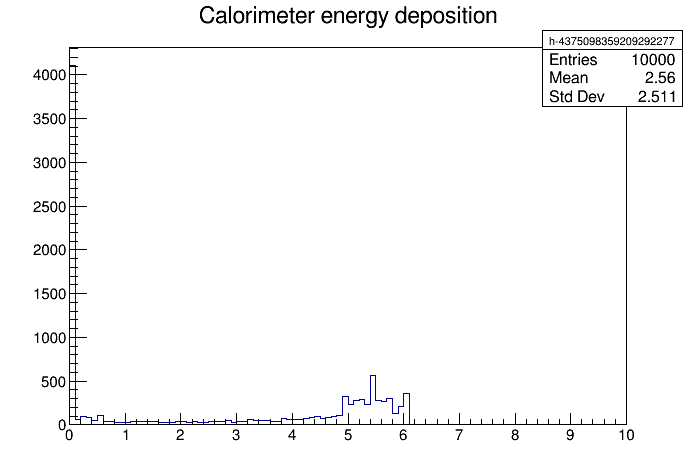

In [17]:
#Гистограмма энергий в калориметре
canvas1 = ROOT.TCanvas("canvas1", "Data1")
canvas1.cd()
calorimeter.hist.Draw()
canvas1.Draw()

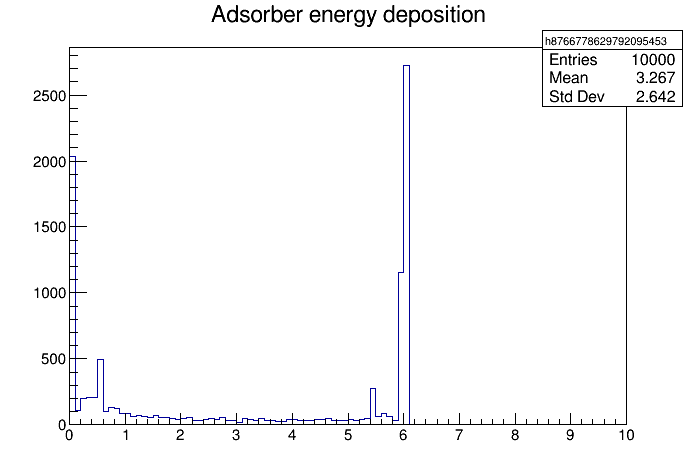

In [18]:
#Гистограмма энергий в поглотителе
canvas2 = ROOT.TCanvas("canvas2", "Data2")
canvas2.cd()
adsorber.hist.Draw()
canvas2.Draw()

In [19]:
print('Probability of full adsorption:', calorimeter.count_full_adsorb/10000)

Probability of full adsorption: 0.0564


In [20]:
print('Ratio: ', calorimeter.total_energy/(calorimeter.total_energy + adsorber.total_energy))

Ratio:  0.4393348897684296
